# Import Libraries 

In [1]:
import os
import numpy as np
from numpy import save, asarray
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
import pickle as pkl
import tensorflow as tf

from tensorflow import keras
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
## Load data using pickle
def unloadPickle(file):
    with open(file, 'rb') as f:
        temp =  pkl.load(f, encoding='latin1')
    return temp

## Extract train and test data and reshape images to (32, 32, 3)
def extractData(dataPath, dataStr):
    
    if dataStr == '\data_batch_':
        X_train = []
        y_train = []

        for i in range(1, 6):
            filePath = dataPath + dataStr + str(i)
            file = unloadPickle(filePath)
            file['data'] = file['data'].reshape((len(file['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
            X_train.append(file['data'])
            y_train.append(file['labels'])
            
        metaFile = unloadPickle(os.path.join(dataPath,'batches.meta'))
        labelNames = metaFile['label_names']
        
        return X_train, y_train, labelNames
    
    elif dataStr == 'test_batch':    
        
        filePath = os.path.join(dataPath, dataStr)
        file = unloadPickle(filePath)
        file['data'] = file['data'].reshape((len(file['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
        X_test = file['data']
        y_test = file['labels']
    
        return X_test, y_test

## Display the statistics of the data and display the image based on the batch and sample image    
def displayStats(dataPath, dataStr, batch_id, sample_id):
    
    X, y, labelNames = extractData(dataPath, dataStr)
    
    features = []
    labels = []
    
    print('No. of batches : {}'.format(len(X)))
    print('No. of samples in each batch : {}'.format(len(X[batch_id])))
    print('Shape of each sample : {}'.format(X[batch_id - 1][sample_id].shape))
    print('\nStats of batch {}'.format(batch_id))
    print('\nCount of each label in batch {} : '.format(batch_id))
    
    label_counts = dict(zip(*np.unique(y[batch_id - 1], return_counts=True)))
    
    for key, value in label_counts.items():
        print('No. of {} images : {}'.format((labelNames[key]).upper(), value))
    
    sample_label = y[batch_id - 1][sample_id]
    print('\nSample Id : {}, Image name : {}'.format(sample_id, (labelNames[sample_label]).upper()))
    sample_image = X[batch_id - 1][sample_id]
    plt.imshow(sample_image)

## One hot encode the labels
def oneHotEncode(labels):
    
    x = np.zeros((len(labels), 10))
    for i, j in enumerate(labels):
        x[i][j] = 1
    
    return x

## Cannot use this function as it is returning binary values instead of values between 0 to 1
## Normalize the image
# def normImage(image):
    
#     image = image.astype('float32')   
#     image /= 255
    
#     return image

## Perform the pre-processing steps
# def preprocessData(X, y):
               
#     for j, img in enumerate(X):
#         img = img.astype('float32')
#         img /= 255
#         X[j] = img
#         #X[j] = tf.random_crop()
        
#     y = oneHotEncode(y)
            
#     return X, y

## Dump the train or test data in pickle files
def saveData(batch_features, batch_labels, filename):
    
    pkl.dump((batch_features, batch_labels), open(filename, 'wb'))
    
def schedulerLr(epoch, lr):
    if epoch < lr:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

## Display Train vs Validation loss and accuracy graphs    
def metrics_graph(model, num_epoch):
    
    r_ep = range(num_epoch)
    train_loss = model.history['loss']
    validation_loss = model.history['val_loss']
    train_acuracy = model.history['accuracy']
    validation_accuracy = model.history['val_accuracy']

    plt.figure(figsize=(15,7))
    
    plt.subplot(1, 2, 1)
    plt.title('Train vs Validation')
    plt.plot(r_ep, train_loss)
    plt.plot(r_ep, validation_loss)
    plt.legend(['train_loss', 'val_loss'])
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.title('Train Accuracy vs Validation Accuracy')
    plt.plot(r_ep, train_acuracy)
    plt.plot(r_ep, validation_accuracy)
    plt.legend(['train_acc', 'val_acc'])
    plt.xlabel('No. of epochs')
    plt.ylabel('Accuracy')

# Load Dataset 

In [3]:
os.chdir("../..")
dataPath = os.path.join(os.getcwd(), 'ImageClassification\\archive\cifar-10-batches-py')
print(dataPath)

D:\Competetions\Kaggle\ImageClassification\archive\cifar-10-batches-py


No. of batches : 5
No. of samples in each batch : 10000
Shape of each sample : (32, 32, 3)

Stats of batch 1

Count of each label in batch 1 : 
No. of AIRPLANE images : 1005
No. of AUTOMOBILE images : 974
No. of BIRD images : 1032
No. of CAT images : 1016
No. of DEER images : 999
No. of DOG images : 937
No. of FROG images : 1030
No. of HORSE images : 1001
No. of SHIP images : 1025
No. of TRUCK images : 981

Sample Id : 123, Image name : BIRD


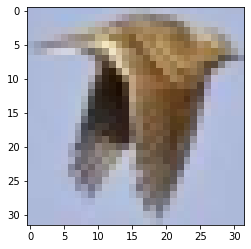

In [4]:
trainStr = '\data_batch_'
testStr = 'test_batch'

displayStats(dataPath, trainStr, 1, 123)

In [5]:
feat, lbl, labelNames = extractData(dataPath, trainStr)

# Pre-processing

In [16]:
batch_ids = [1, 2, 3, 4, 5]
train_feat, train_lbl = [], []
for b_id in batch_ids:
    temp_batch = []
    for idx, img in enumerate(feat[i-1]):
        temp_batch.append(feat[b_id-1][idx] / 255.0)
    train_feat.append(asarray(temp_batch)) 
    train_lbl.append(oneHotEncode(lbl[b_id-1]))
    
    saveData(train_feat[b_id-1], train_lbl[b_id-1], os.path.join(dataPath, 'prcsd_batch_' + str(b_id) + '.pkl'))

In [7]:
X, y = extractData(dataPath, testStr)
X_test, y_test = [], []
for idx, img in enumerate(X):
    X[idx] = X[idx].astype('float32')
    X_test.append(X[idx] / 255.0)

X_test = asarray(X_test)    
y_test = oneHotEncode(y)
saveData(X_test, y_test, os.path.join(dataPath, 'prcsd_test_batch.pkl'))

# Model Generation

### Loading saved processed data 

In [6]:
train_features = []
train_labels = []
batch_ids = [1, 2, 3, 4, 5]
for b_id in batch_ids:
    path = os.path.join(dataPath, 'prcsd_batch_' + str(b_id) + '.pkl')
    temp_batch = unloadPickle(path)
    train_features.append(temp_batch[0]) 
    train_labels.append(temp_batch[1])

In [7]:
X_train_features, y_train_labels = np.concatenate(train_features, axis = 0), np.concatenate(train_labels, axis = 0)

In [8]:
test_path = os.path.join(dataPath, 'prcsd_test_batch.pkl')
X_test, y_test = unloadPickle(test_path)

In [9]:
X_train, X_train_val, y_train, y_train_val = train_test_split(X_train_features, 
                                                                  y_train_labels, 
                                                                  test_size=0.2, 
                                                                  random_state=42)

## Sample Model 

In [7]:
def cnnModel(feature_shape, labels, learning_rate):
    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(4, 4), input_shape=feature_shape, activation='relu'))
    model.add(MaxPool2D(2, 2))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(labels, activation='softmax'))
    
    opt = Adam(learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [8]:
callback = tf.keras.callbacks.LearningRateScheduler(schedulerLr)

In [18]:
feature_shape = X_train[0].shape
labels = len(y_train[0])
#dropout_rate = 0.25
num_epoch = 30
learning_rate = 0.001
decay_rate = learning_rate / num_epoch
momentum = 0.8

model = cnnModel(feature_shape, labels, learning_rate)
#model.summary()
cnn_model = model.fit(X_train, y_train, 
                          epochs = num_epoch, 
                          batch_size = 32, 
                          callbacks=[callback],
                          validation_data=(X_train_val, y_train_val))

Epoch 1/30
1250/1250 [==============================] - 8s 6ms/step - loss: 1.6029 - accuracy: 0.4220 - val_loss: 1.3702 - val_accuracy: 0.5102 - lr: 0.0010
Epoch 2/30
1250/1250 [==============================] - 50s 40ms/step - loss: 1.3133 - accuracy: 0.5335 - val_loss: 1.2946 - val_accuracy: 0.5445 - lr: 9.0484e-04
Epoch 3/30
1250/1250 [==============================] - 45s 36ms/step - loss: 1.2118 - accuracy: 0.5734 - val_loss: 1.2143 - val_accuracy: 0.5706 - lr: 8.1873e-04
Epoch 4/30
1250/1250 [==============================] - 36s 29ms/step - loss: 1.1377 - accuracy: 0.6036 - val_loss: 1.1791 - val_accuracy: 0.5916 - lr: 7.4082e-04
Epoch 5/30
1250/1250 [==============================] - 35s 28ms/step - loss: 1.0778 - accuracy: 0.6261 - val_loss: 1.1411 - val_accuracy: 0.6014 - lr: 6.7032e-04
Epoch 6/30
1250/1250 [==============================] - 40s 32ms/step - loss: 1.0296 - accuracy: 0.6401 - val_loss: 1.0967 - val_accuracy: 0.6162 - lr: 6.0653e-04
Epoch 7/30
1250/1250 [======

In [19]:
## Save the model
model.save(os.path.join(dataPath, 'SampleModel.h5'))
print('Saved sample model to disk')

Saved sample model to disk


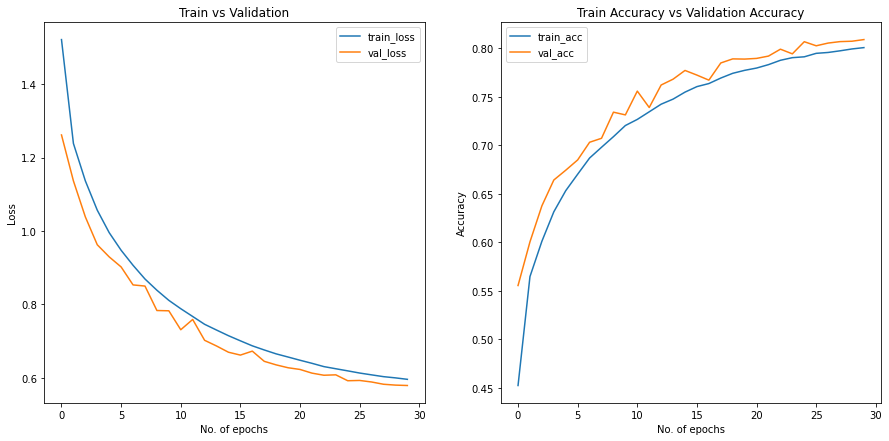

In [20]:
metrics_graph(cnn_model, num_epoch)

### Evaluate the model 

In [61]:
smpl_model = load_model(os.path.join(dataPath, 'SampleModel.h5'))

eval_model = smpl_model.evaluate(X_test, y_test)
print('Test loss: ', eval_model[0])
print('Test accuracy: ', eval_model[1])

313/313 [==============================] - 1s 2ms/step - loss: 1.0749 - accuracy: 0.6396
Test loss:  1.0749012231826782
Test accuracy:  0.6395999789237976


### Prediction

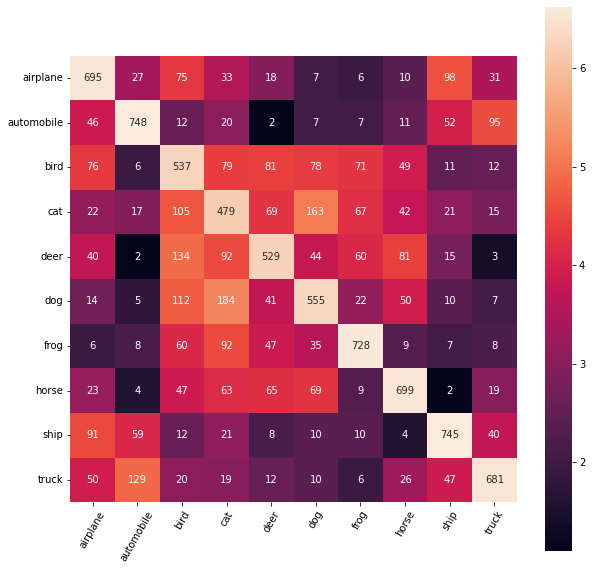

In [37]:
y_pred = smpl_model.predict(X_test)
y_pred_cat = np.argmax(y_pred, axis=1)

y_test_cat = np.argmax(y_test, axis=1)

cm_smpl_model = confusion_matrix(y_test_cat, y_pred_cat)

plt.figure(figsize=(10,10))
sns.heatmap(np.log1p(cm_smpl_model), annot=cm_smpl_model, fmt='d', 
            xticklabels=labelNames, yticklabels=labelNames, square=True)
plt.xticks(rotation=60)
plt.show()

## Model 1 

In [51]:
def cnnModel1(feature_shape, labels, learning_rate, dropout_rate):
    
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(3, 3), input_shape=feature_shape, activation='relu', padding='same'))
    model.add(MaxPool2D(2, 2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(2, 2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(2, 2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(2, 2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(2, 2))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(labels, activation='softmax'))
    
    opt = Adam(learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [52]:
callback = tf.keras.callbacks.LearningRateScheduler(schedulerLr)

In [53]:
feature_shape = X_train[0].shape
labels = len(y_train[0])
dropout_rate = 0.25
num_epoch = 30
learning_rate = 0.001
decay_rate = learning_rate / num_epoch
momentum = 0.8

model1 = cnnModel1(feature_shape, labels, learning_rate, dropout_rate)
#model.summary()
cnn_model1 = model1.fit(X_train, y_train, 
                          epochs = num_epoch, 
                          batch_size = 128, 
                          callbacks=[callback],
                          validation_data=(X_train_val, y_train_val))

Epoch 1/30
313/313 [==============================] - 38s 119ms/step - loss: 1.6240 - accuracy: 0.4056 - val_loss: 5.6923 - val_accuracy: 0.0996 - lr: 0.0010
Epoch 2/30
313/313 [==============================] - 40s 127ms/step - loss: 1.2134 - accuracy: 0.5641 - val_loss: 1.4531 - val_accuracy: 0.5017 - lr: 9.0484e-04
Epoch 3/30
313/313 [==============================] - 59s 187ms/step - loss: 1.0347 - accuracy: 0.6314 - val_loss: 0.9317 - val_accuracy: 0.6713 - lr: 8.1873e-04
Epoch 4/30
313/313 [==============================] - 37s 118ms/step - loss: 0.9145 - accuracy: 0.6750 - val_loss: 0.9277 - val_accuracy: 0.6847 - lr: 7.4082e-04
Epoch 5/30
313/313 [==============================] - 80s 254ms/step - loss: 0.8289 - accuracy: 0.7110 - val_loss: 0.9817 - val_accuracy: 0.6607 - lr: 6.7032e-04
Epoch 6/30
313/313 [==============================] - 59s 189ms/step - loss: 0.7546 - accuracy: 0.7348 - val_loss: 0.7660 - val_accuracy: 0.7279 - lr: 6.0653e-04
Epoch 7/30
313/313 [============

In [55]:
## Save the model
model1.save(os.path.join(dataPath, 'Model1.h5'))
print('Saved model1 to disk')

Saved model1 to disk


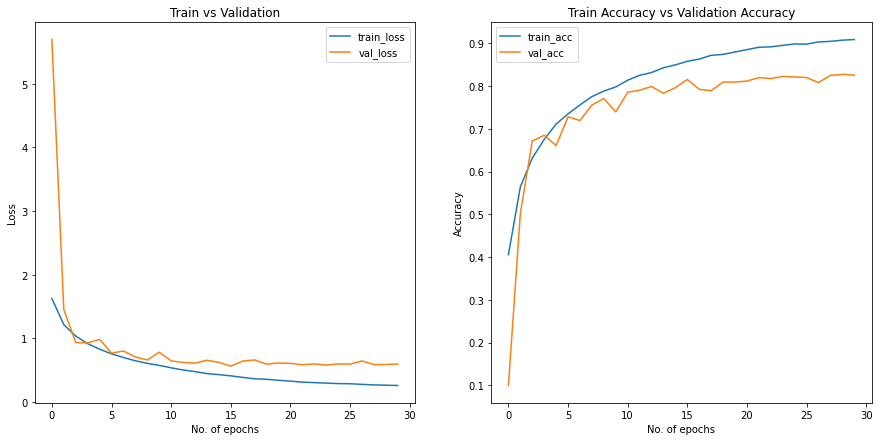

In [54]:
metrics_graph(cnn_model1, num_epoch)

### Evaluate the model 

In [62]:
load_model1 = load_model(os.path.join(dataPath, 'Model1.h5'))

eval_model1 = load_model1.evaluate(X_test, y_test)
print('Test loss: ', eval_model1[0])
print('Test accuracy: ', eval_model1[1])

313/313 [==============================] - 3s 10ms/step - loss: 0.6364 - accuracy: 0.8127
Test loss:  0.6363579630851746
Test accuracy:  0.8126999735832214


### Prediction 

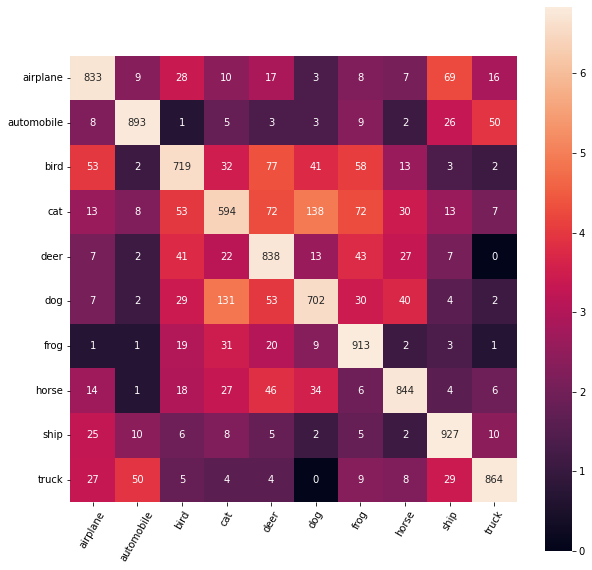

In [60]:
y_pred = load_model1.predict(X_test)
y_pred_cat = np.argmax(y_pred, axis=1)

y_test_cat = np.argmax(y_test, axis=1)

cm_model1 = confusion_matrix(y_test_cat, y_pred_cat)

plt.figure(figsize=(10,10))
sns.heatmap(np.log1p(cm_model1), annot=cm_model1, fmt='d', 
            xticklabels=labelNames, yticklabels=labelNames, square=True)
plt.xticks(rotation=60)
plt.show()

## Model 2 with Augmentation

In [10]:
datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True, 
    vertical_flip=False
)

datagen.fit(X_train)

In [11]:
def cnnModel2(feature_shape, labels, learning_rate, dropout_rate):
    
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=feature_shape, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2, 2))
    #model.add(Dropout(dropout_rate))
    
    model.add(Conv2D(64, kernel_size=(3, 3), input_shape=feature_shape, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2, 2))
    #model.add(Dropout(dropout_rate))
    
    model.add(Conv2D(128, kernel_size=(3, 3), input_shape=feature_shape, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2, 2))
    #model.add(Dropout(dropout_rate))
    
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(labels, activation='softmax'))
    
    
    opt = Adam(learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [12]:
callback = tf.keras.callbacks.LearningRateScheduler(schedulerLr)

In [13]:
feature_shape = X_train[0].shape
labels = len(y_train[0])
dropout_rate = 0.5
num_epoch = 60
learning_rate = 0.001
decay_rate = learning_rate / num_epoch
momentum = 0.8

model2 = cnnModel2(feature_shape, labels, learning_rate, dropout_rate)
#model2.summary()
cnn_model2 = model2.fit_generator(datagen.flow(X_train, y_train, batch_size = 128), 
                                  steps_per_epoch=len(X_train)/128,
                                  epochs = num_epoch,  
                                  validation_data=(X_train_val, y_train_val), 
                                  shuffle=True)

Epoch 1/60
312/312 [==============================] - 152s 484ms/step - loss: 1.6637 - accuracy: 0.4189 - val_loss: 2.7970 - val_accuracy: 0.1790
Epoch 2/60
312/312 [==============================] - 151s 484ms/step - loss: 1.2678 - accuracy: 0.5478 - val_loss: 1.1004 - val_accuracy: 0.6003
Epoch 3/60
312/312 [==============================] - 164s 524ms/step - loss: 1.1043 - accuracy: 0.6125 - val_loss: 1.1646 - val_accuracy: 0.6092
Epoch 4/60
312/312 [==============================] - 157s 501ms/step - loss: 0.9864 - accuracy: 0.6550 - val_loss: 1.1701 - val_accuracy: 0.6153
Epoch 5/60
312/312 [==============================] - 168s 538ms/step - loss: 0.9009 - accuracy: 0.6858 - val_loss: 0.7724 - val_accuracy: 0.7329
Epoch 6/60
312/312 [==============================] - 163s 521ms/step - loss: 0.8435 - accuracy: 0.7101 - val_loss: 0.8916 - val_accuracy: 0.7068
Epoch 7/60
312/312 [==============================] - 161s 515ms/step - loss: 0.7901 - accuracy: 0.7293 - val_loss: 0.6871 -

312/312 [==============================] - 249s 795ms/step - loss: 0.2644 - accuracy: 0.9089 - val_loss: 0.4267 - val_accuracy: 0.8711
Epoch 58/60
312/312 [==============================] - 250s 800ms/step - loss: 0.2582 - accuracy: 0.9114 - val_loss: 0.4026 - val_accuracy: 0.8725
Epoch 59/60
312/312 [==============================] - 253s 811ms/step - loss: 0.2592 - accuracy: 0.9109 - val_loss: 0.4596 - val_accuracy: 0.8672
Epoch 60/60
312/312 [==============================] - 292s 935ms/step - loss: 0.2543 - accuracy: 0.9121 - val_loss: 0.4486 - val_accuracy: 0.8651


In [14]:
## Save the model
model2.save(os.path.join(dataPath, 'Model2.h5'))
print('Saved model2 to disk')

Saved model2 to disk


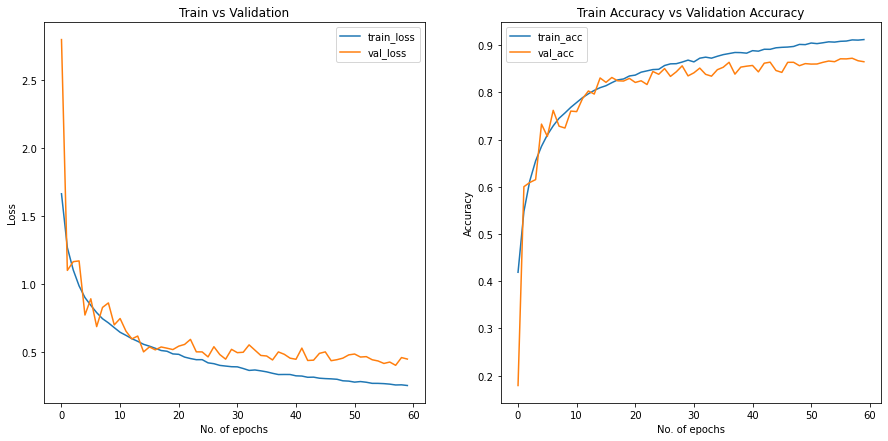

In [15]:
metrics_graph(cnn_model2, num_epoch)

### Evaluate the model 

In [16]:
load_model2 = load_model(os.path.join(dataPath, 'Model2.h5'))

eval_model2 = load_model2.evaluate(X_test, y_test)
print('Test loss: ', eval_model2[0])
print('Test accuracy: ', eval_model2[1])

313/313 [==============================] - 4s 11ms/step - loss: 0.4618 - accuracy: 0.8665
Test loss:  0.46175292134284973
Test accuracy:  0.8665000200271606


### Prediction 

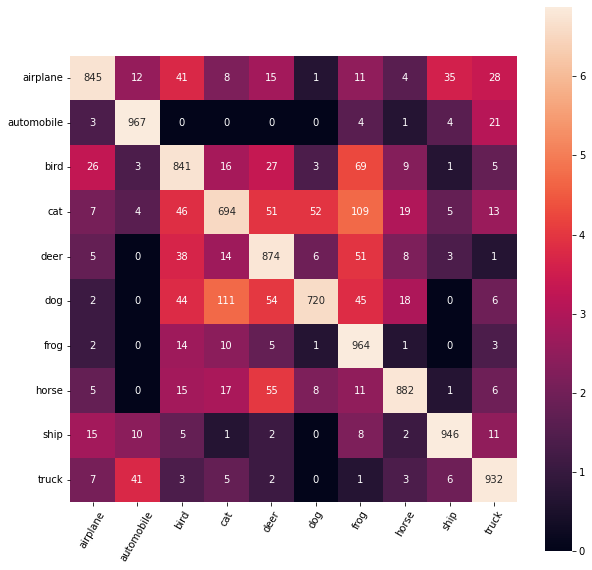

In [17]:
y_pred = load_model2.predict(X_test)
y_pred_cat = np.argmax(y_pred, axis=1)

y_test_cat = np.argmax(y_test, axis=1)

cm_model2 = confusion_matrix(y_test_cat, y_pred_cat)

plt.figure(figsize=(10,10))
sns.heatmap(np.log1p(cm_model2), annot=cm_model2, fmt='d', 
            xticklabels=labelNames, yticklabels=labelNames, square=True)
plt.xticks(rotation=60)
plt.show()